# Qtie 
## Quantum Intelligence

We present to you Qtie, the Quantum Intelligence. Using the power of quantum computation combined with classical methods for machine learning, Qutie exploits the fundamental phenomena of physical reality to take classification to the next level.

# Concept and Dataset Prep

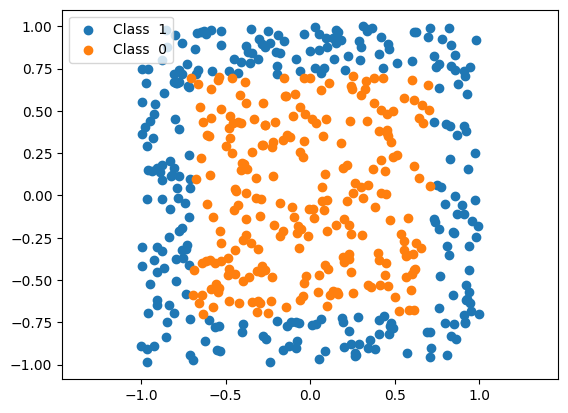

In [250]:
import numpy as np
import matplotlib.pyplot as plt

## Set random seed so results are repeatable
np.random.seed(2025)

## Underlying classification, outside of square or inside
def underlying_function(R: np.ndarray) -> float:
    return np.max(np.abs(R), axis=1) > 1/np.sqrt(2)


## Prepare random dataset
Nsamples = 500
R = 2*np.random.random((Nsamples,2)) - np.array([1,1])  # Data points, uniform in [-1,1]x[-1,1]

Y = underlying_function(R)   # Classification
Y_int = np.array([1 if y else 0 for y in Y]) # Save as integers for later

R_class1 = R[Y]                    # Class +1: Outside of square
R_class0 = R[np.logical_not( Y )]  # Class  0: Inside  of square

plt.axis('equal')
plt.scatter(R_class1[:,0], R_class1[:,1], label="Class  1")
plt.scatter(R_class0[:,0], R_class0[:,1], label="Class  0")
plt.legend(loc = "upper left")

# Qtie Implementation

## Quantum Circuit Preparation

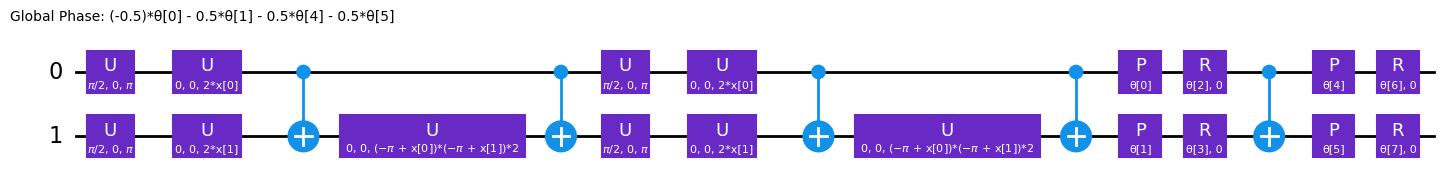

In [251]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import zz_feature_map
from qiskit.circuit.library import efficient_su2, RealAmplitudes

N_QBITS = 2
INPUT_PARAMETERS = ParameterVector('x', N_QBITS)

def encoding(n_qbits:int) -> QuantumCircuit:
    """Returns an encoder that will encode a point in space (x,y) into a quantum circuit.
    """
    return zz_feature_map(n_qbits)

def processing(n_qbits:int) -> QuantumCircuit:
    """Returns a processing layer that will be trained to try to solve our problem
    """
    return efficient_su2(n_qbits, ['rz','rx'], reps=1)
    # return RealAmplitudes(n_qbits)

encoding_circuit = encoding(N_QBITS)
processing_circuit = processing(N_QBITS)

## Assign our Parameter Vectors
TRAINABLE_PARAMETERS = ParameterVector('θ', processing_circuit.num_parameters)

encoding_circuit.assign_parameters(INPUT_PARAMETERS, inplace=True)
processing_circuit.assign_parameters(TRAINABLE_PARAMETERS, inplace=True)

## Define our QNN Circuit
qnn_circuit = encoding_circuit.compose(processing_circuit)

## DRAWING
# encoding_circuit.decompose().draw(output='mpl', style='textbook')
# processing_circuit.decompose().draw(output='mpl', style='textbook')
qnn_circuit.decompose().draw(output='mpl', style='textbook')

## Forward Function Definition

In [252]:
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftSamplerGradient

BACKEND = AerSimulator()

def forward(circuit: QuantumCircuit, inputs_dict: dict, trainable_params_dict: dict, sampler: Sampler, num_shots: int = int(1e5)):
    """ "Forward pass of the Q neural network", returns output probability vector of circuit for |00>, |01>, |10> |11>
    """
    _circuit = circuit.assign_parameters(inputs_dict)
    _circuit.assign_parameters(trainable_params_dict, inplace=True)
    _circuit.measure_all()

    job = sampler.run([_circuit], shots=num_shots)
    result = job.result()
    result_counts = result[0].data.meas.get_counts()
    
    return np.array([result_counts.get('00',0), result_counts.get('01',0), result_counts.get('10',0), result_counts.get('11',0)])/num_shots
    
def backwards(qnn_circuit: QuantumCircuit, inputs: np.ndarray, trainable_parameters: np.ndarray, sampler: Sampler) -> np.ndarray:
    
    return 


def interpret_qc_result(probability_vector: np.array):
    # sum the prob. of 01 and 00, and compare to the sum of 10 and 11.
    final_vector = np.array([np.sum(probability_vector[:2]), np.sum(probability_vector[2:])])
    return np.argmax(final_vector)


## Mean Error Calculation

In [253]:
def calculate_loss(x_vec: np.array, y_vec: np.array, theta: np.array):
    error_sum = 0
    for x_i,y_i in zip(x_vec,y_vec):
        output_state_probF = forward(circuit = qnn_circuit, 
                                    inputs_dict = {INPUT_PARAMETERS[0]: x_i[0], INPUT_PARAMETERS[1]: x_i[1]}, 
                                    trainable_params_dict= {TRAINABLE_PARAMETERS: theta},
                                    sampler=Sampler(mode=BACKEND),
                                    num_shots=int(1e3)
                                    )

        y_qc = interpret_qc_result(output_state_probF)
        error_sum += (y_qc - y_i)**2
    return error_sum

## Minimization

In [254]:
from scipy.optimize import minimize

def loss_fun(theta):
    return calculate_loss(R,Y_int,theta)

maxiter = 20
np.random.seed(36)
init_param = np.random.rand(qnn_circuit.num_parameters-N_QBITS)

minimization_result = minimize(
    loss_fun,
    init_param,
    method="COBYLA",
    options={"maxiter":maxiter}    
)

minimization_result

 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: 76.0
       x: [ 6.610e-01  5.158e-01 -9.047e-02  9.406e-02  7.905e-01
            3.233e-01  1.260e+00 -2.209e-01]
    nfev: 20
   maxcv: 0.0

## Classifier

In [255]:
class QNNClassifier:
    def __init__(self, circuit, sampler, params):
        self.circuit = circuit
        self.sampler = sampler
        self.params = params  # vector entrenado
    
    def predict(self, R):
        predictions = []
        for x in R:
            probability_vector = forward(
                circuit=self.circuit,
                inputs_dict={INPUT_PARAMETERS: x},
                trainable_params_dict={TRAINABLE_PARAMETERS: self.params},
                sampler=self.sampler,
                num_shots=int(1e3)
            )
            # Ejemplo: predicción binaria según la probabilidad del primer estado
            predictions.append(interpret_qc_result(probability_vector))
        return np.array(predictions)

## Plotting

Accuracy:  0.844


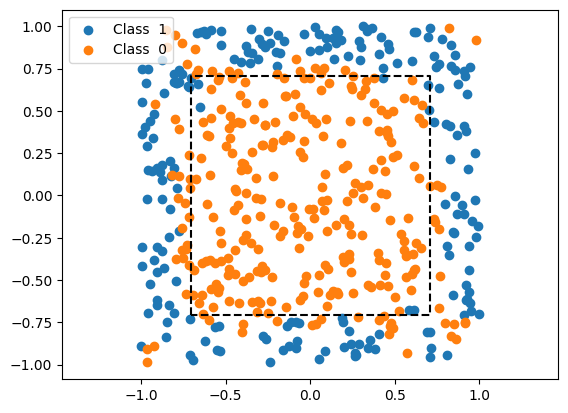

In [256]:
# Plotting
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)

QNN_classifier = QNNClassifier(
    circuit=qnn_circuit,
    sampler=Sampler(mode=BACKEND),
    params=minimization_result.x)

def plot_prediction(QNN_classifier):
    """Auxiliar function to plot classification. Feel free to modify it"""
    # Making prediction
    prediction = QNN_classifier.predict(R)

    is_one = prediction == 1

    predicted_R_class1 = R[is_one]                    # Class +1: Outside of square
    predicted_R_class0 = R[np.logical_not( is_one )]  # Class  0: Inside  of square

    ## PLOT Prediction
    plt.axis('equal')

    # Accuracy
    print('Accuracy: ',np.array(prediction == Y_int).sum()/len(Y_int))

    # Draw square
    plt.plot([-np.sqrt(2)/2, -np.sqrt(2)/2, np.sqrt(2)/2, np.sqrt(2)/2, -np.sqrt(2)/2], [-np.sqrt(2)/2, np.sqrt(2)/2, np.sqrt(2)/2, -np.sqrt(2)/2, -np.sqrt(2)/2], 'k--')
    plt.scatter(predicted_R_class1[:,0], predicted_R_class1[:,1], label="Class  1")
    plt.scatter(predicted_R_class0[:,0], predicted_R_class0[:,1], label="Class  0")
    plt.legend(loc = "upper left")

plot_prediction(QNN_classifier)

In [257]:
# Save weights
import datetime as dt
now = dt.datetime.now()
np.savetxt(f'thetas_{now.hour,now.minute}.csv', minimization_result.x, delimiter=',')

# Qtie on Phase Recognition

In [258]:
from qiskit.quantum_info import SparsePauliOp

def XY_hamiltonian(gamma: float, h: float, Nsites: int) -> SparsePauliOp:
    paulis = []
    Coeff_X = -(1 + gamma) / 2
    Coeff_y = -(1 - gamma) / 2
    for i in range(Nsites):
        j = (i + 1) % Nsites
        paulis.append(("XX", [i, j], Coeff_X))
        paulis.append(("YY", [i, j], Coeff_y))
    for i in range(Nsites):
        paulis.append(("Z", [i], -h))
    return SparsePauliOp.from_sparse_list(paulis, num_qubits=Nsites)

import numpy as np
from scipy.sparse.linalg import eigsh

def XY_ground_state(gamma: float, h: float, Nsites: int):
    H = XY_hamiltonian(gamma=gamma, h=h, Nsites=Nsites)
    H_matrix = H.to_matrix(sparse=True)
    vals, vecs = eigsh(H_matrix, k=N_QBITS, which='SA')
    return vals, vecs


vals, vecs = XY_ground_state(gamma=0.5, h=1, Nsites=N_QBITS)
E0 = np.min(vals)
E1 = np.partition(vals, 1)[1]  

print("Eigenvalues:", vals)
print("Ground state Energy (E0):", float(E0))
print("First excited energy (E1):", float(E1))
print("Energy gap (E1 - E0):", float(E1 - E0))

print("\nGround state vector:")
print(vecs[:, 0])

Eigenvalues: [-2.23606798 -2.        ]
Ground state Energy (E0): -2.2360679774997894
First excited energy (E1): -2.0
Energy gap (E1 - E0): 0.23606797749978936

Ground state vector:
[-7.83669433e-01-5.77127209e-01j -1.52655666e-16-3.88578059e-16j
 -1.66533454e-16-3.88578059e-16j -1.84999258e-01-1.36241253e-01j]


## Dataset preparation

In [259]:
import numpy as np
from scipy.sparse.linalg import eigsh
import pandas as pd
import json

Nsites = 2
num_samples = 5000

h_vals = np.random.uniform(0.0, 2.0, num_samples)
gamma_vals = np.random.uniform(0.0, 2.0, num_samples)

def phase_label(gamma: float, h: float) -> int:
    if h > 1.0:
        return 0
    r2 = gamma**2 + h**2
    return 1 if r2 > 1.0 else 2

def XY_ground_state(gamma: float, h: float, Nsites: int):
    H = XY_hamiltonian(gamma=gamma, h=h, Nsites=Nsites)
    H_matrix = H.to_matrix(sparse=True)
    vals, vecs = eigsh(H_matrix, k=1, which='SA')
    E0 = float(vals[0])
    gs = vecs[:, 0] / np.linalg.norm(vecs[:, 0])
    return E0, gs

E0_vals = np.zeros(num_samples, dtype=np.float32)
labels = np.zeros(num_samples, dtype=np.int8)
gammas = np.zeros(num_samples, dtype=np.float32)
hs = np.zeros(num_samples, dtype=np.float32)
psi0 = []
psi0_json = []

for i, (h, gamma) in enumerate(zip(h_vals, gamma_vals)):
    E0, gs = XY_ground_state(gamma=gamma, h=h, Nsites=Nsites)
    lbl = phase_label(gamma, h)
    E0_vals[i] = E0
    labels[i] = lbl
    gammas[i] = gamma
    hs[i] = h
    psi0.append(gs)
    psi0_json.append(json.dumps([[float(z.real), float(z.imag)] for z in gs.astype(np.complex64)]))

df = pd.DataFrame({
    "gamma": gammas,
    "h": hs,
    "E0": E0_vals,
    "label": labels,
    "psi0": psi0_json
})
df

,gamma,h,E0,label,psi0
0,0.657149,1.259525,-2.841301,0,"[[0.8782901167869568, 0.4146059453487396], [-5..."
1,0.905391,0.065122,-2.000000,2,"[[3.608224830031759e-16, -6.106226635438361e-1..."
2,1.047216,1.894464,-4.329275,0,"[[-0.15439604222774506, 0.9559057354927063], [..."
3,1.497590,1.808637,-4.696357,0,"[[-0.5115615129470825, 0.7895691990852356], [2..."
4,1.025261,1.100260,-3.007812,0,"[[0.464257150888443, 0.8063908219337463], [-5...."
...,...,...,...,...,...
4995,1.341648,1.164887,-3.553579,0,"[[-0.46621018648147583, -0.7813160419464111], ..."
4996,0.730103,1.327422,-3.029917,0,"[[0.7283366322517395, 0.6384596824645996], [-2..."
4997,1.055188,0.034659,-2.111514,1,"[[0.6964980959892273, 0.17693154513835907], [-..."
4998,0.188285,0.267266,-2.000000,2,"[[-2.220446049250313e-16, -4.336808689942018e-..."


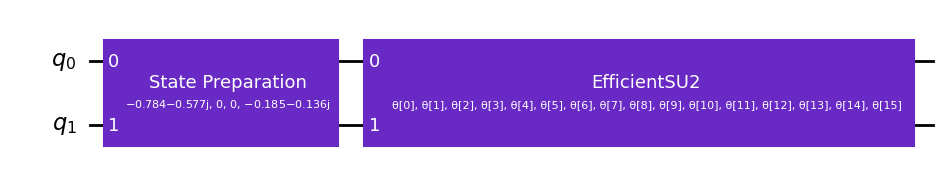

In [260]:
from qiskit.circuit.library import StatePreparation
q_state = StatePreparation(vecs[:, 0])

def create_QNN_circuit(q_state: StatePreparation) -> QuantumCircuit:
    """Returns a Quantum neural Network model that will attempt to solve the phase classification task after trayining.
    """
    qnn_circuit = QuantumCircuit(q_state.num_qubits)
    processing_circuit = efficient_su2(q_state.num_qubits)
    qnn_circuit.append(q_state, qnn_circuit.qubits)
    qnn_circuit.append(processing_circuit, qnn_circuit.qubits)
    return qnn_circuit
qnn = create_QNN_circuit(q_state)
qnn.draw(output='mpl', style='textbook')

## Qtie-QNN 

In [261]:
class Qtie:
    def __init__(self, n_qbits:int, sampler:Sampler, num_shots: int = int(1e5)):
        self.n_qbits = n_qbits
        self.sampler = sampler
        self.num_shots = num_shots
        self.processing_circuit = None
        self.trainable_parameters = None
        self.probability_vector = None
        self.train_states =None
        self.train_labels =None

    def create_processing_circuit(self) -> QuantumCircuit:
        processing_circuit = efficient_su2(self.n_qbits)
        self.trainable_params = ParameterVector('θ', processing_circuit.num_parameters)
        self.processing_circuit = processing_circuit.assign_parameters(self.trainable_params, inplace=False)
        return 
    
    def forward(self, q_state, trainable_params_dict):
        qnn_circuit = QuantumCircuit(self.n_qbits)
        qnn_circuit.append(q_state, qnn_circuit.qubits)
        qnn_circuit.append(self.processing_circuit, qnn_circuit.qubits)
        qnn_circuit.assign_parameters(trainable_params_dict, inplace=True)
        qnn_circuit.measure_all()
        
        sampler = self.sampler
        job = sampler.run([qnn_circuit], shots=self.num_shots)
        result = job.result()
        result_counts = result[0].data.meas.get_counts()
        return np.array([result_counts.get('00',0), result_counts.get('01',0), result_counts.get('10',0), result_counts.get('11',0)])/self.num_shots
   
    def interpret_qc_result(self, probability_vector: np.array):
        return np.argmax(probability_vector)
    
    def calculate_loss(self, q_state_vectors, labels, theta):
        error_sum = 0
        for q_state_i,label_i in zip(q_state_vectors, labels):
            output_state_probF = self.forward(
                                        q_state = q_state_i, 
                                        trainable_params_dict= {self.trainable_params: theta}
                                        )

            y_qc = interpret_qc_result(output_state_probF)
            error_sum += (y_qc - label_i)**2
        return error_sum
    
    def loss_fun(self,theta):
            return self.calculate_loss(self.train_states,self.train_labels,theta)
    
    def train(self, train_states, train_labels):
        self.train_states =train_states
        self.train_labels =train_labels
        maxiter = 10
        init_param = np.random.rand(self.processing_circuit.num_parameters)
        minimization_result = minimize(
            self.loss_fun,
            init_param,
            method="COBYLA",
            options={"maxiter":maxiter}    
        )
        self.params = minimization_result.x
        return

    def predict(self, R):
        predictions = []
        for q_state in R:
            probability_vector = self.forward(
                q_state=q_state,
                trainable_params_dict={TRAINABLE_PARAMETERS: self.params}
            )
            # Ejemplo: predicción binaria según la probabilidad del primer estado
            predictions.append(interpret_qc_result(probability_vector))
        return np.array(predictions)
    
backend = AerSimulator()
qt = Qtie(
    2,
    Sampler(mode=backend)
)

In [262]:
qt.create_processing_circuit()
qt.processing_circuit.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├──■──┤ Ry(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├┤ X ├┤ Ry(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐     ┌───────────┐┌───────────┐
«q_0: ┤ Rz(θ[10]) ├──■──┤ Ry(θ[12]) ├┤ Rz(θ[14]) ├
«     ├───────────┤┌─┴─┐├───────────┤├───────────┤
«q_1: ┤ Rz(θ[11]) ├┤ X ├┤ Ry(θ[13]) ├┤ Rz(θ[15]) ├
«     └───────────┘└───┘└───────────┘└───────────┘

In [263]:
qt.train(
    psi0[:10],
    labels[:10]
)

TypeError: issubclass() arg 1 must be a class